In [1]:
import pandas as pd 

In [2]:
def report(df,place=0):
    column_names = df.columns.to_list()
    row = df.iloc[place]
    for i in range(0,len(column_names)):
        print(column_names[i],':',row[i])

#### Загрузка таблицы

In [3]:
df = pd.read_csv("ttl_aug_03.csv",';')
df.fillna(0, inplace=True)

#### Приведение смещений к числу

def convert_to_int(s):
    return float(s.rsplit(',', 2)[0].replace(' ',''))/1000

#df['bias_top']=df['bias_top'].apply(convert_to_int)
#df['bias_bottom']=df['bias_bottom'].apply(convert_to_int)

report(df)

#### Определим время жизни пакетов

In [4]:
def get_len(last_string):
    splitters = ['*','a','b','c','d','e','f','g','h','i','j']
    ttl = []
    for splitter in splitters:
        new_string = last_string.split(splitter)
        last_string = new_string[1]
        ttl.append(new_string[0])
    ttl.append(last_string)
    first_value = int(ttl[2])
    last_value = int(ttl[-2:][0])
    return last_value-first_value

df['dev_len']=df['ttl'].apply(get_len)

report(df)

id : 15 088 503
date : 02.08.2020 0:01:57
phone : 9154847271
ttl : bidlist*a1596315713355b1596315714854c1596315714854d1596326514084e1596326515803f1596315716742g1596315716742h1596315715651i1596315715700j1596326516412
AppVersion : 589
dev_len : 2345


#### Выделим функцию

In [5]:
def get_func(last_string):
    return last_string.split('*')[0]
df['func']=df['ttl'].apply(get_func)

report(df)

id : 15 088 503
date : 02.08.2020 0:01:57
phone : 9154847271
ttl : bidlist*a1596315713355b1596315714854c1596315714854d1596326514084e1596326515803f1596315716742g1596315716742h1596315715651i1596315715700j1596326516412
AppVersion : 589
dev_len : 2345
func : bidlist


#### Заполним таймеры этапов

In [6]:
def get_timers(last_string,step):
    splitters = ['*','a','b','c','d','e','f','g','h','i','j']
    ttl = []
    for splitter in splitters:
        new_string = last_string.split(splitter)
        last_string = new_string[1]
        ttl.append(new_string[0])
    ttl.append(last_string)    
    return int(ttl[step])/1000

timer_columns = ['a','b','c','d','e','f','g','h','i','j']
for i in range(0,len(timer_columns)):
    column_name = timer_columns[i]
    df[column_name]=df['ttl'].apply(get_timers,step=i+2)

report(df)

id : 15 088 503
date : 02.08.2020 0:01:57
phone : 9154847271
ttl : bidlist*a1596315713355b1596315714854c1596315714854d1596326514084e1596326515803f1596315716742g1596315716742h1596315715651i1596315715700j1596326516412
AppVersion : 589
dev_len : 2345
func : bidlist
a : 1596315713.355
b : 1596315714.854
c : 1596315714.854
d : 1596326514.084
e : 1596326515.803
f : 1596315716.742
g : 1596315716.742
h : 1596315715.651
i : 1596315715.7
j : 1596326516.412


#### Определим смещение по записи с минимальной длительностью в мс для каждого номера телефона

In [7]:
for phone in df["phone"].unique():
    mr = df[df.phone==phone].sort_values(by=['dev_len']).iloc[0] #minimal delay record
    bias_top=(mr.h-mr.a-(mr.g-mr.b))/2-(mr.b-mr.a)
    bias_bottom=(mr.f+bias_top-(mr.c+bias_top)-(mr.e-mr.d))/2-(mr.d-(mr.c+bias_top))
    df.loc[df['phone'] == phone, 'bias_top'] = bias_top    
    df.loc[df['phone'] == phone, 'bias_bottom'] = bias_bottom

#### Вычислим время между инстанциями

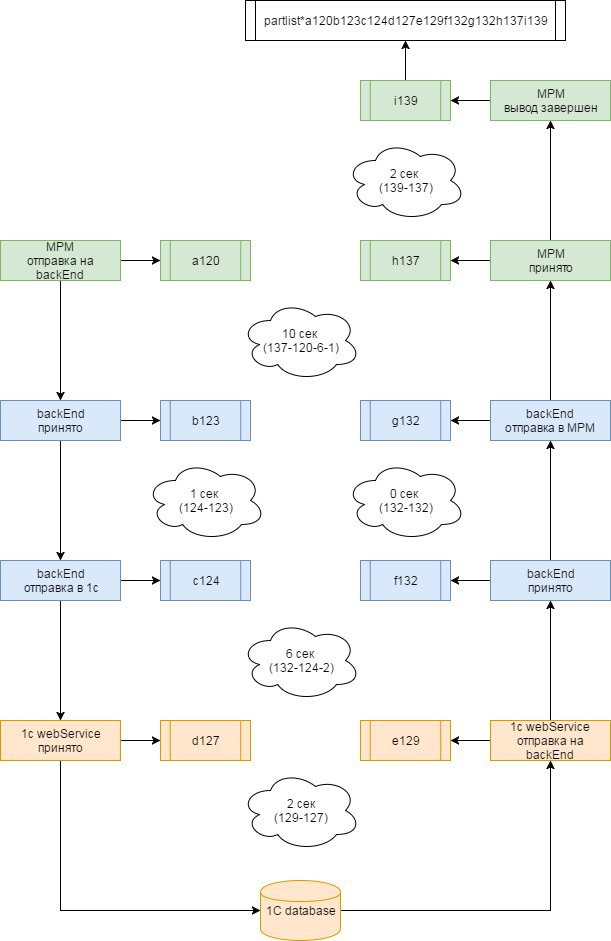

In [8]:
df['ab_mrm_to_back']      = df.b - df.a + df.bias_top    
df['bc_back_to_back']     = df.c - df.b
df['cd_back_to_1c']       = df.d - df.c + df.bias_bottom - df.bias_top
df['de_1c_to_1c']         = df.e - df.d
df['ef_1c_to_back']       = df.f - df.e + df.bias_top - df.bias_bottom
df['fg_back_to_back']     = df.g - df.f
df['gh_back_to_mrm']      = df.h - df.g - df.bias_top
df['hi_mrm_to_mrm']       = df.i - df.h

report(df,0)

id : 15 088 503
date : 02.08.2020 0:01:57
phone : 9154847271
ttl : bidlist*a1596315713355b1596315714854c1596315714854d1596326514084e1596326515803f1596315716742g1596315716742h1596315715651i1596315715700j1596326516412
AppVersion : 589
dev_len : 2345
func : bidlist
a : 1596315713.355
b : 1596315714.854
c : 1596315714.854
d : 1596326514.084
e : 1596326515.803
f : 1596315716.742
g : 1596315716.742
h : 1596315715.651
i : 1596315715.7
j : 1596326516.412
bias_top : -0.4869999885559082
bias_bottom : -10799.616999864578
ab_mrm_to_back : 1.0120000839233398
bc_back_to_back : 0.0
cd_back_to_1c : 0.10000014305114746
de_1c_to_1c : 1.7189998626708984
ef_1c_to_back : 0.0690000057220459
fg_back_to_back : 0.0
gh_back_to_mrm : -0.6040000915527344
hi_mrm_to_mrm : 0.04900002479553223


#### График по версиям

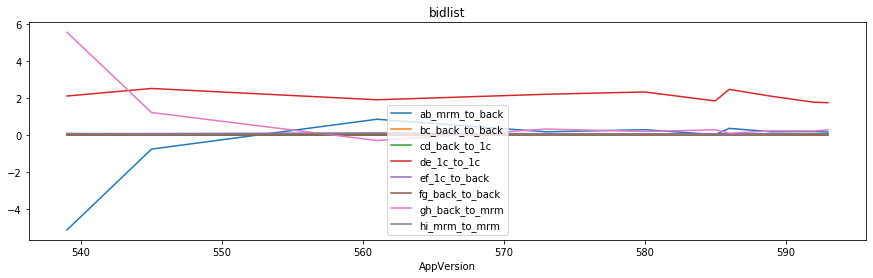

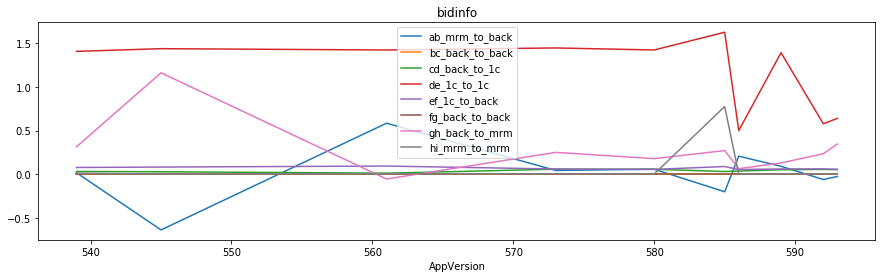

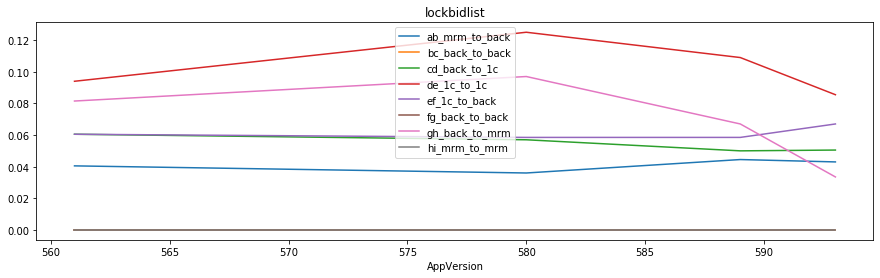

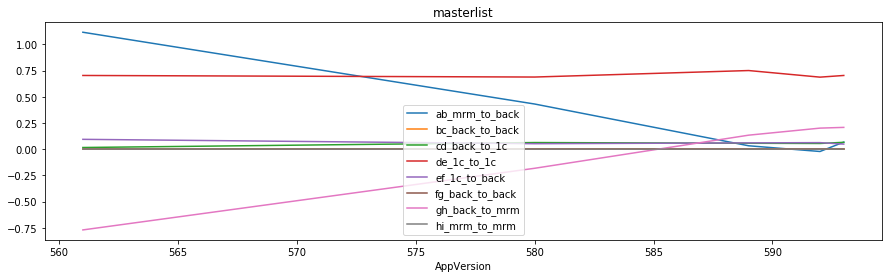

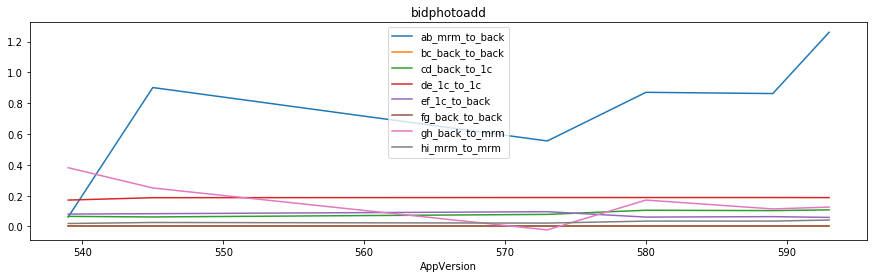

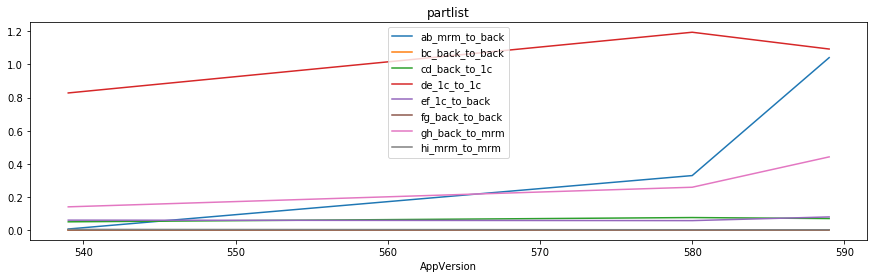

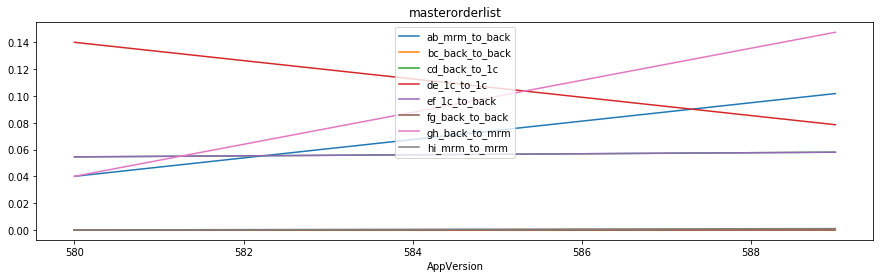

In [11]:
def plot_functions(df):
    for func in df['func'].unique():
        df[df.func==func].groupby('AppVersion').median().plot(
            y=[
                'ab_mrm_to_back',
                'bc_back_to_back',
                'cd_back_to_1c',
                'de_1c_to_1c',
                'ef_1c_to_back',
                'fg_back_to_back',
                'gh_back_to_mrm',
                'hi_mrm_to_mrm',
            ],
            title = func,
            #subplots=True,
            figsize=(15,4)
        )
plot_functions(df)